In [50]:
# General Imports

from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import uproot3
import pandas

from matplotlib.colors import LogNorm
import scipy.signal
from scipy import optimize
from numpy.fft import fft, ifft, ifftshift
from matplotlib.colors import LogNorm

In [51]:
# Plotting style file

plt.style.use("LateLightStyle.mplstyle")

In [52]:
# Simulate 10000 photons in a 200 ticks time window

# Function for simulating an aribtrary amount of photons
def simpureres(n, reslength, A0, tau):
    resfun = np.zeros(reslength, dtype="float")
    t = np.random.rand(n) * reslength
    A = np.random.rand(n) * A0
    i = 0
    for i in range(n):
        if A[i] <= A0*np.exp(-t[i]/tau):
# Note: The function int() here always rounds down, so each time bins are always on the right hand side of the value of its index.
            resfun[int(t[i])] += 1
            #resfun[int(t[i])] += A[i]
        else:
            pass
    return resfun

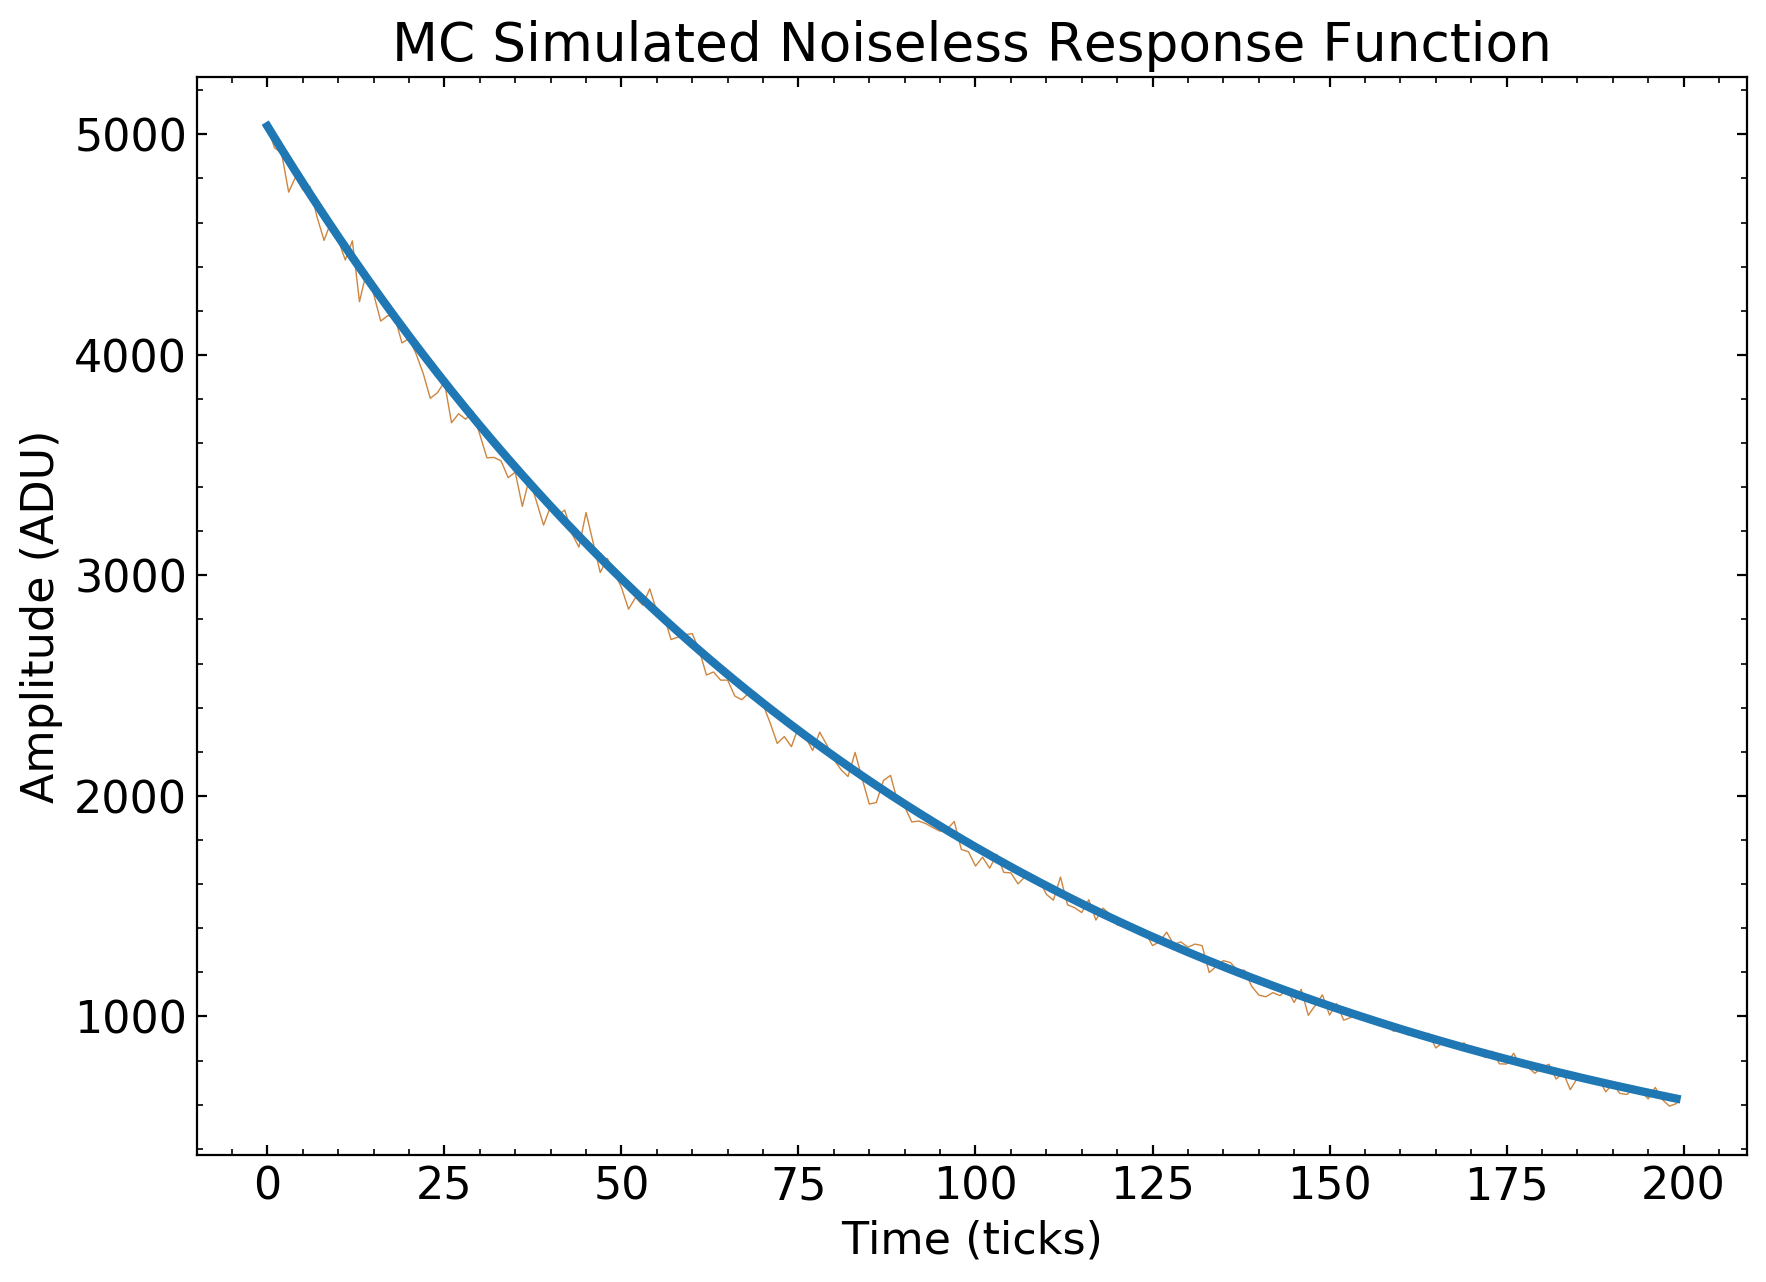

In [53]:
ntest = 1000000
reslengthtest = 200
A0test = 500
tautest = 1500/15.625

pureres = simpureres(ntest, reslengthtest, A0test, tautest)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(pureres, color="peru", linewidth=0.5)
#ax.plot([ntest*np.exp(-i/tautest) for i in np.linspace(0,200,200)])
ax.plot([max(pureres)*np.exp(-i/tautest) for i in np.linspace(0,200,200)])
ax.set_title("MC Simulated Noiseless Response Function")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
#ax.set_xlim(0,200)
plt.show()

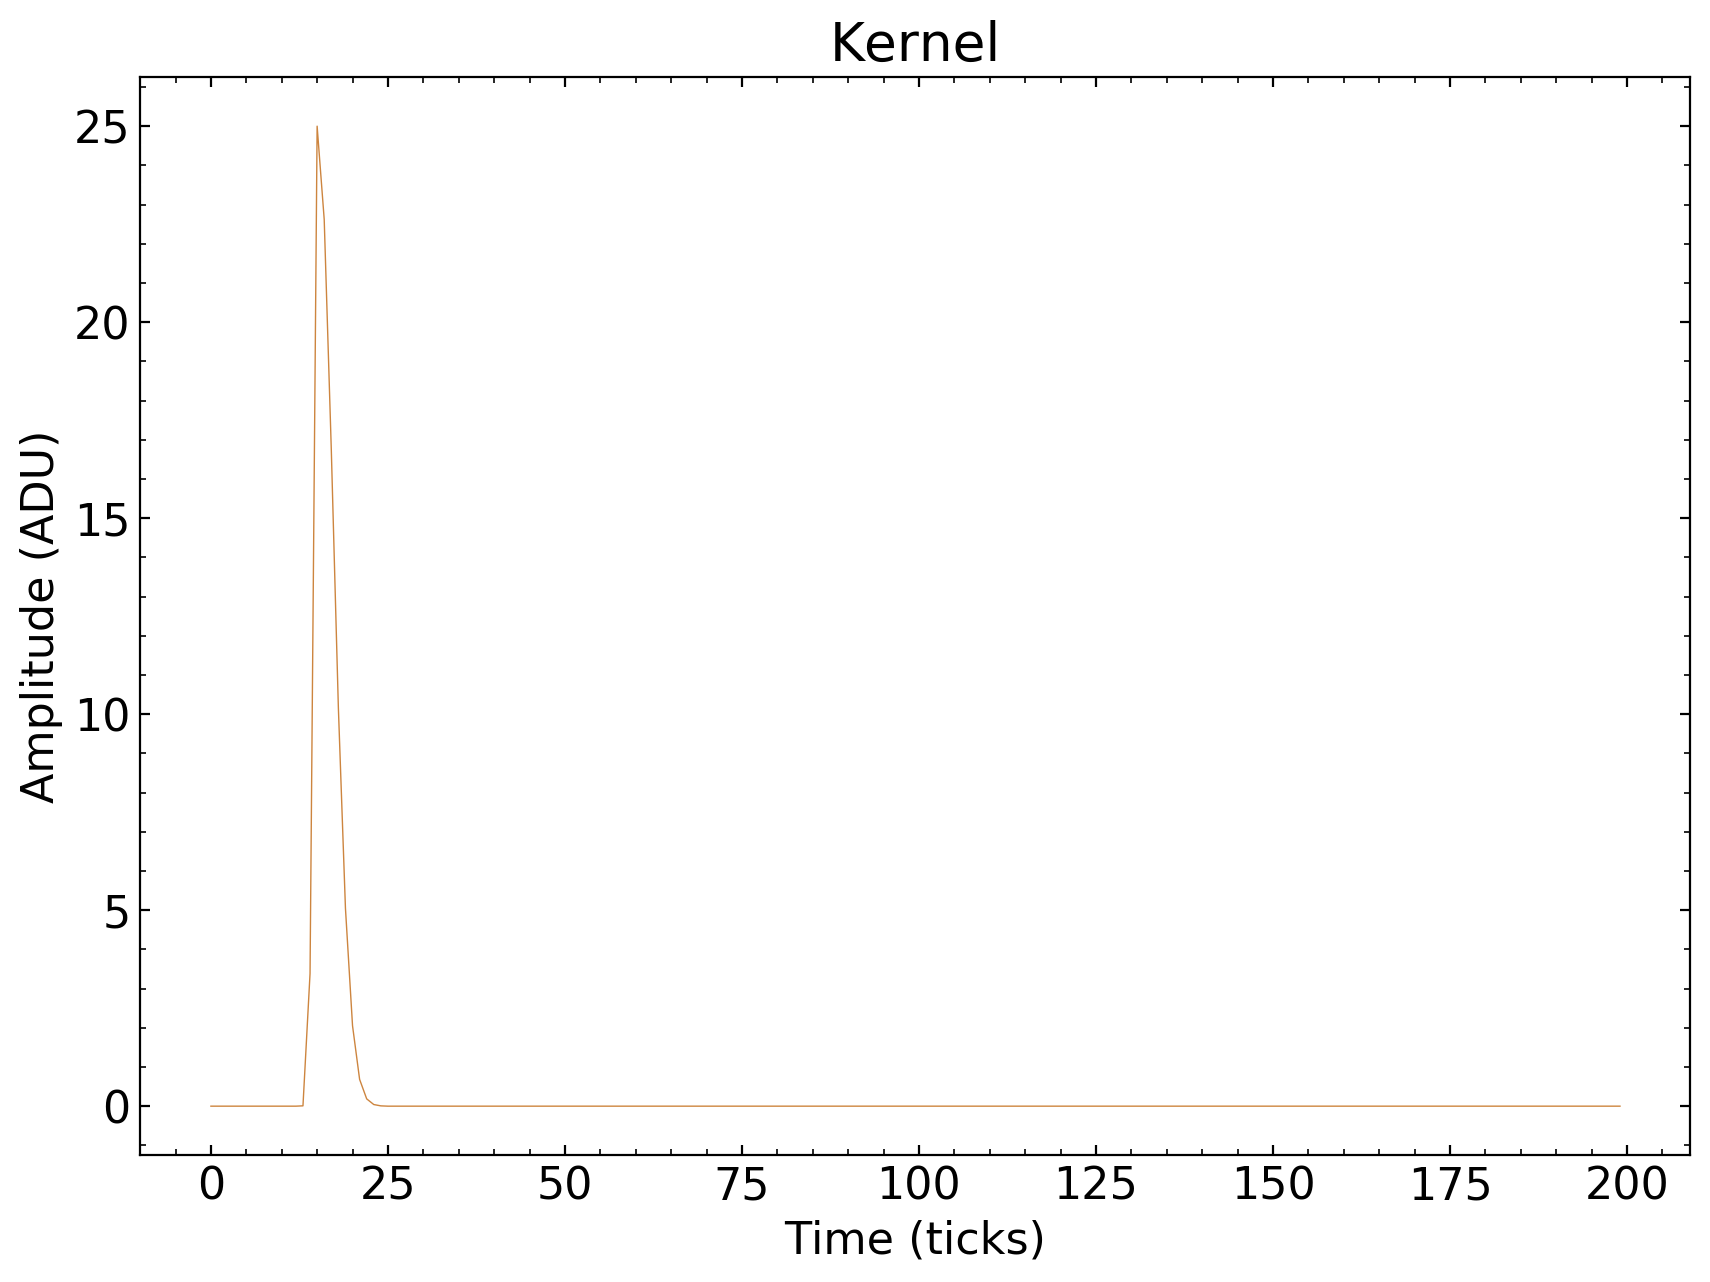

In [54]:
# Next step: Add noise to the system using a defined kernel + some additive noise
# Issue to report to juno: kernel dies after returning to app

# Build a kernel
testkernel = np.zeros(reslengthtest)
# Introduce some SPE peak (IMPORTANT: SPE peak at tick 15)
testkernel[5:25] = [25*np.exp(-2*i**2) for i in range(-10,0)] + [25*np.exp(-i**2/10) for i in range(0,10)]

# Plot the kernel
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(testkernel, color="peru", linewidth=0.5)
ax.set_title("Kernel")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
#ax.set_xlim(12,200)
plt.show()

In [55]:
# Generate response function convolved with the kernel
# Function for simulating an aribtrary amount of photons
def simres(n, reslength, A0, tau, kernel):
    resfun = np.zeros(reslength, dtype="float")
    t = np.random.rand(n) * reslength
    A = np.random.rand(n) * A0
    i = 0
    for i in range(n):
        if A[i] <= A0*np.exp(-t[i]/tau):
            tbin = int(t[i])
# Note: The function int() here always rounds down, so each time bins are always on the right hand side of the value of its index.
            #resfun[int(t[i]):-12] += kernel[12:len(resfun[int(t[i]):])]
# add the prepulse (SPE peak arrives at tick 15, anything before that is considered prepulse)
            for j in range(0,min([15,tbin])):
                resfun[tbin-j] += kernel[15-j]
            #resfun[int(t[i])-12:int(t[i])] += kernel[:12]
            # add the afterpulse
            tend = min([len(resfun[tbin:]), len(kernel[15:])])
            resfun[tbin:tbin+tend] += kernel[15:15+tend]
            #resfun[int(t[i])] += A[i]
        else:
            pass
    return resfun

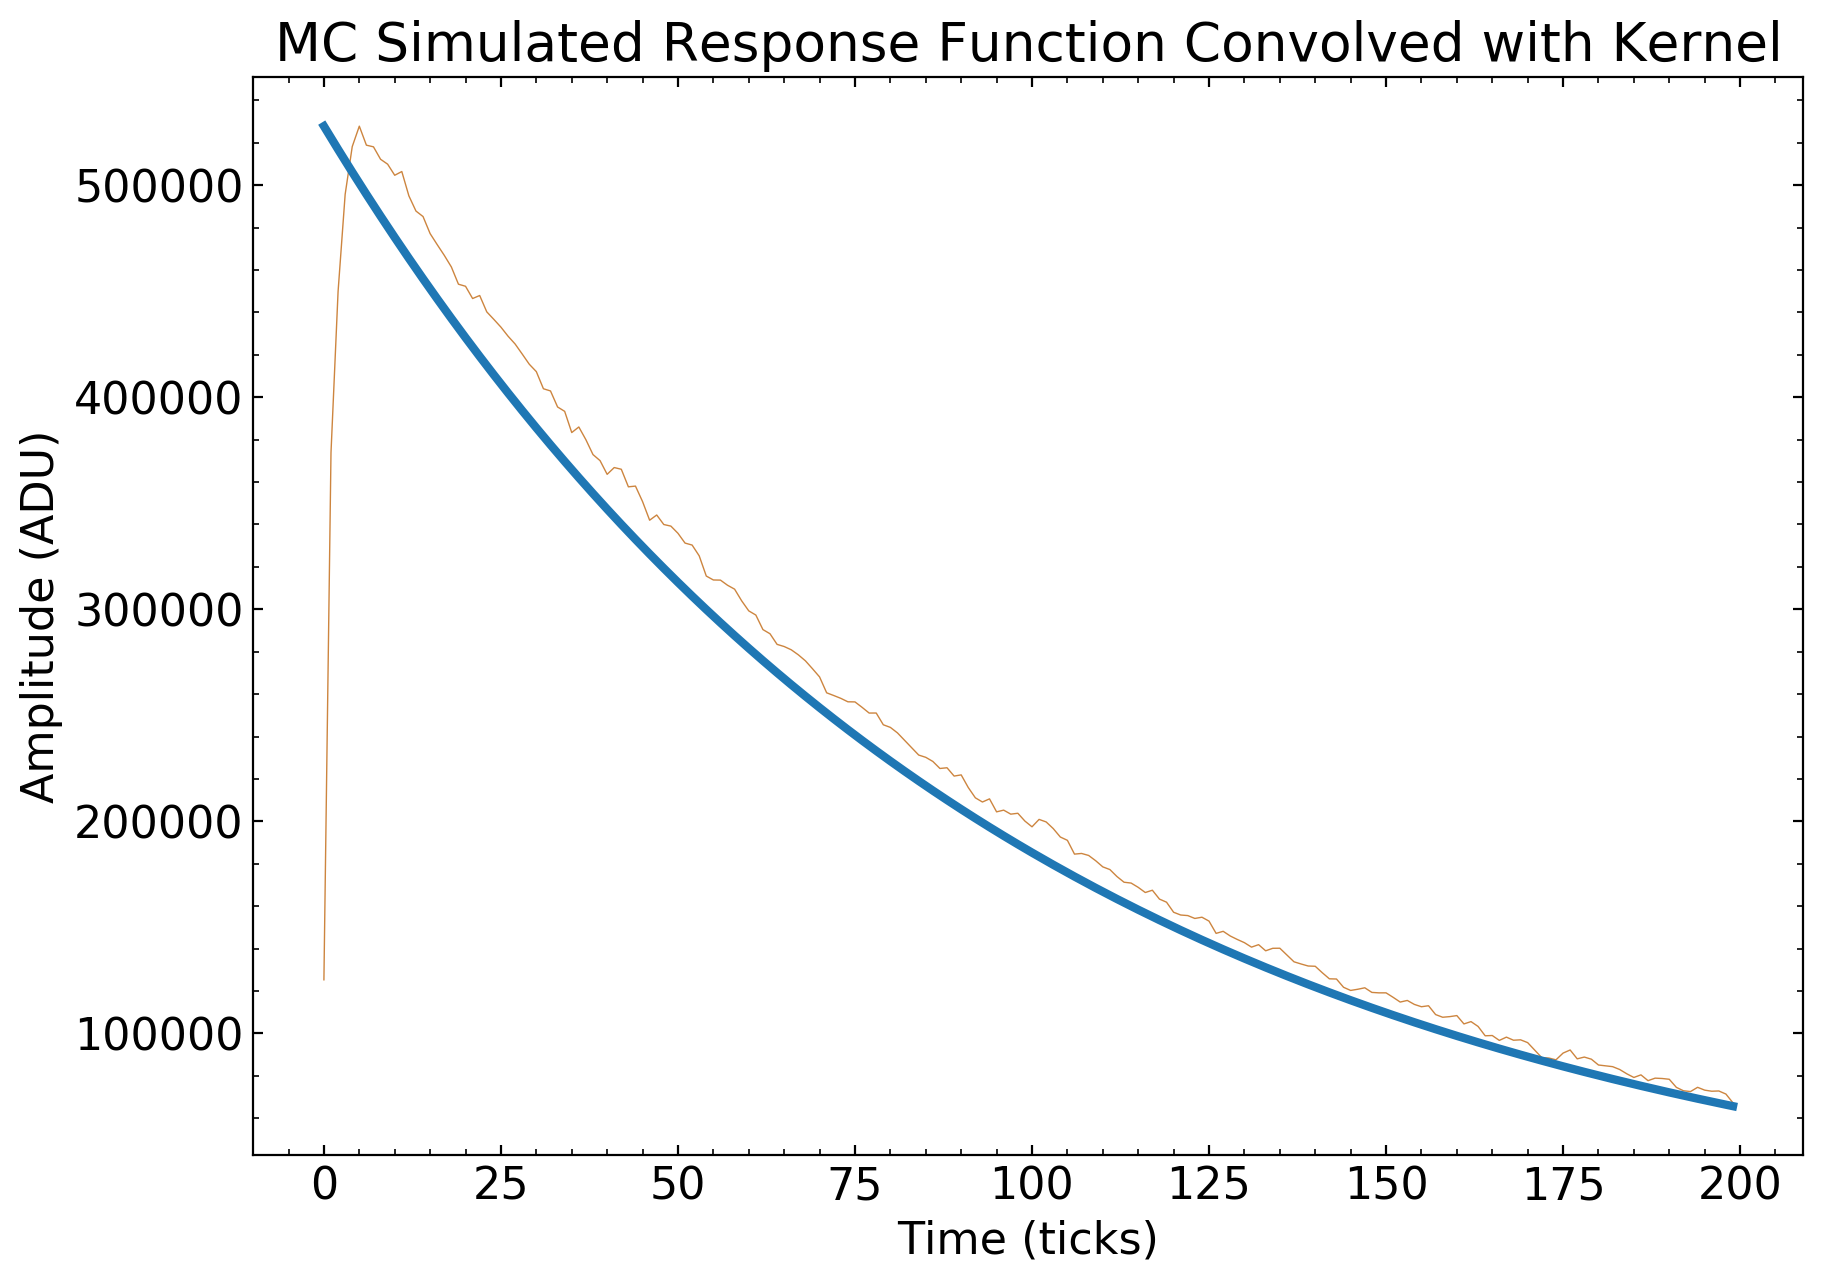

In [56]:
kres = simres(ntest, reslengthtest, A0test, tautest, testkernel)

fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(kres, color="peru", linewidth=0.5)
#ax.plot([ntest*np.exp(-i/tautest) for i in np.linspace(0,200,200)])
ax.plot([max(kres)*np.exp(-i/tautest) for i in np.linspace(0,200,200)])
ax.set_title("MC Simulated Response Function Convolved with Kernel")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
#ax.set_xlim(0,200)
plt.show()

In [57]:
# perform existing latelight analysis on the convolved signal

# SPE rate / tick / event
# SPErate = 3.12e-3 * pass2

# https://gist.github.com/danstowell/f2d81a897df9e23cc1da
def wiener_deconvolution(signal, kernel, lambd):
    #"lambd is the inverse SNR"
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
    return deconvolved

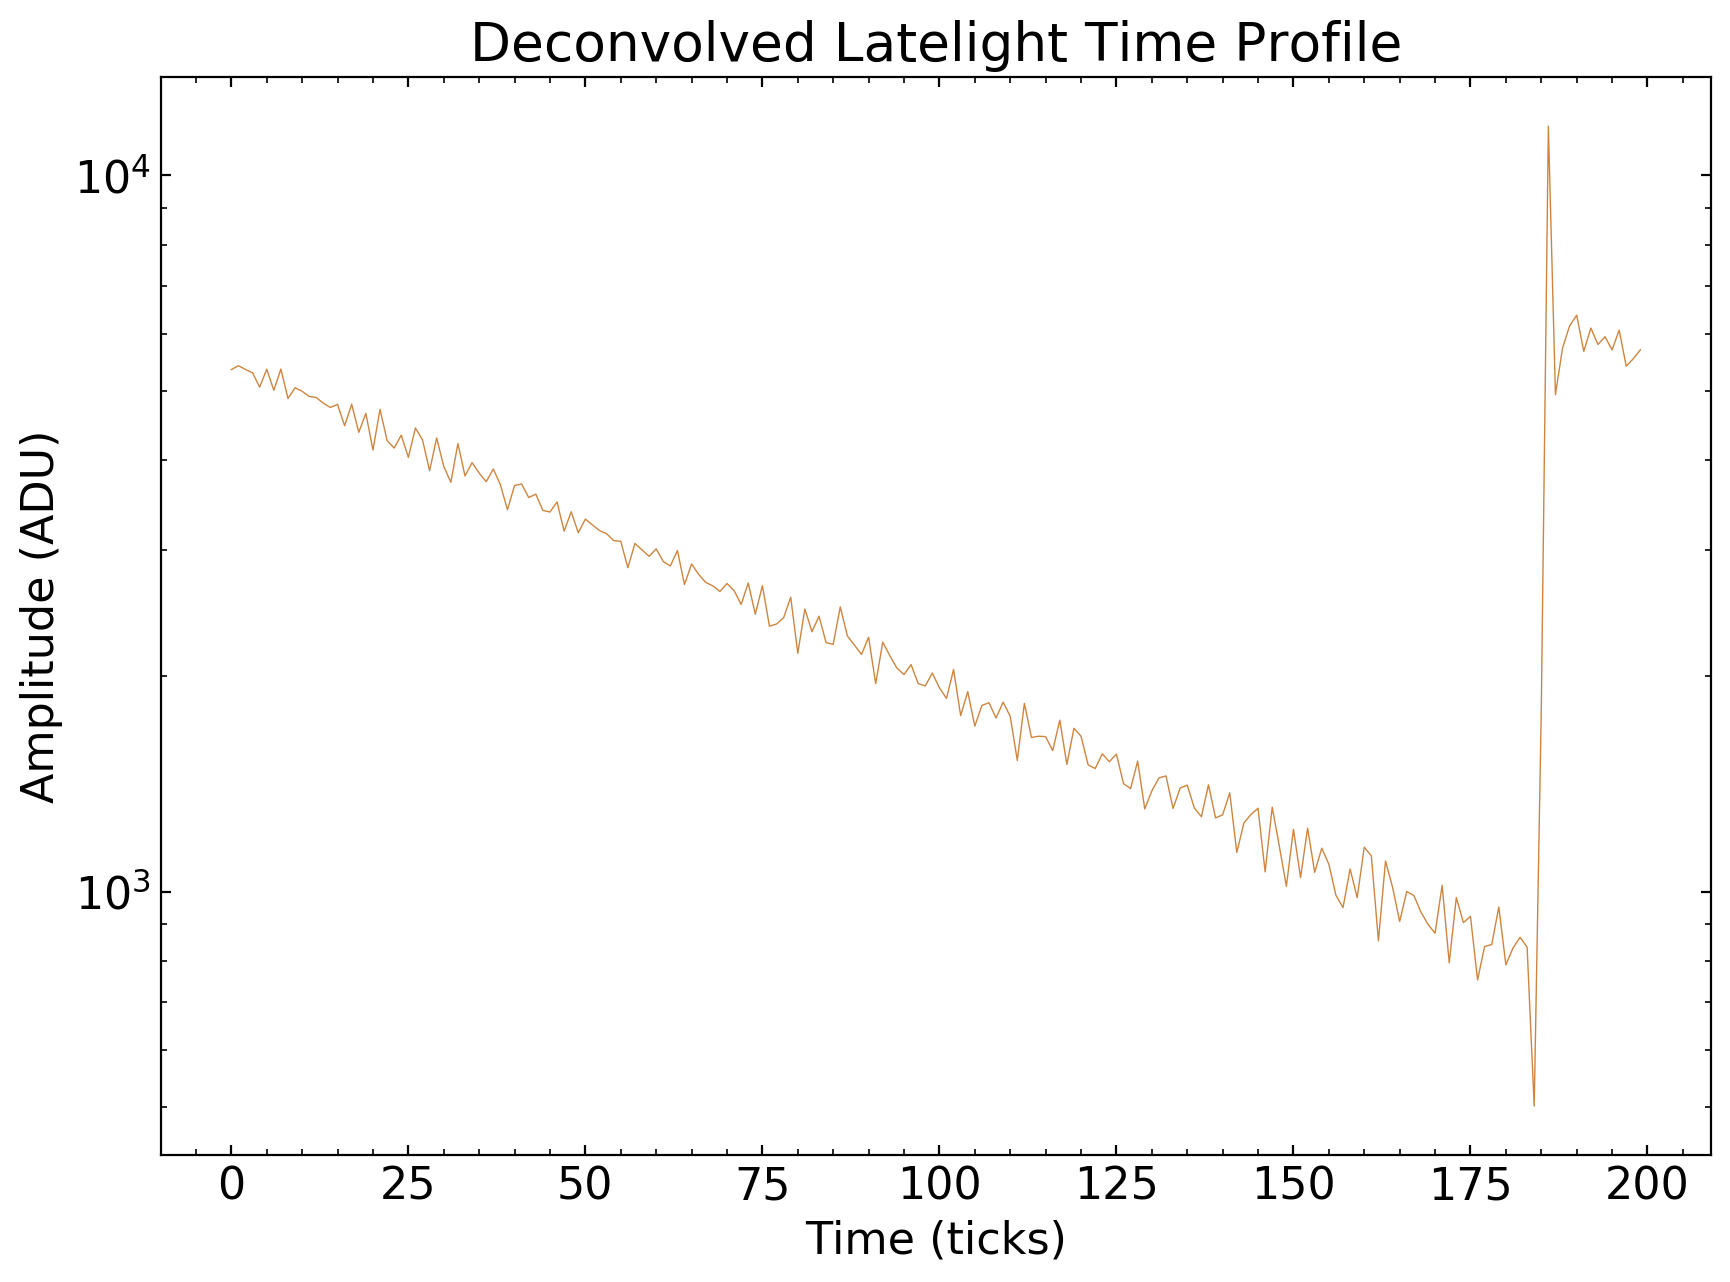

In [58]:
dc_res = wiener_deconvolution(kres, testkernel, 1/1000)
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(dc_res, color="peru", linewidth=0.5)
ax.set_title("Deconvolved Latelight Time Profile")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
#ax.set_xlim(0,200)
plt.yscale("log")
plt.show()

In [59]:
# Exponetial fit function

def expfun(t, tau, a):
    return a*np.exp(-t/tau)

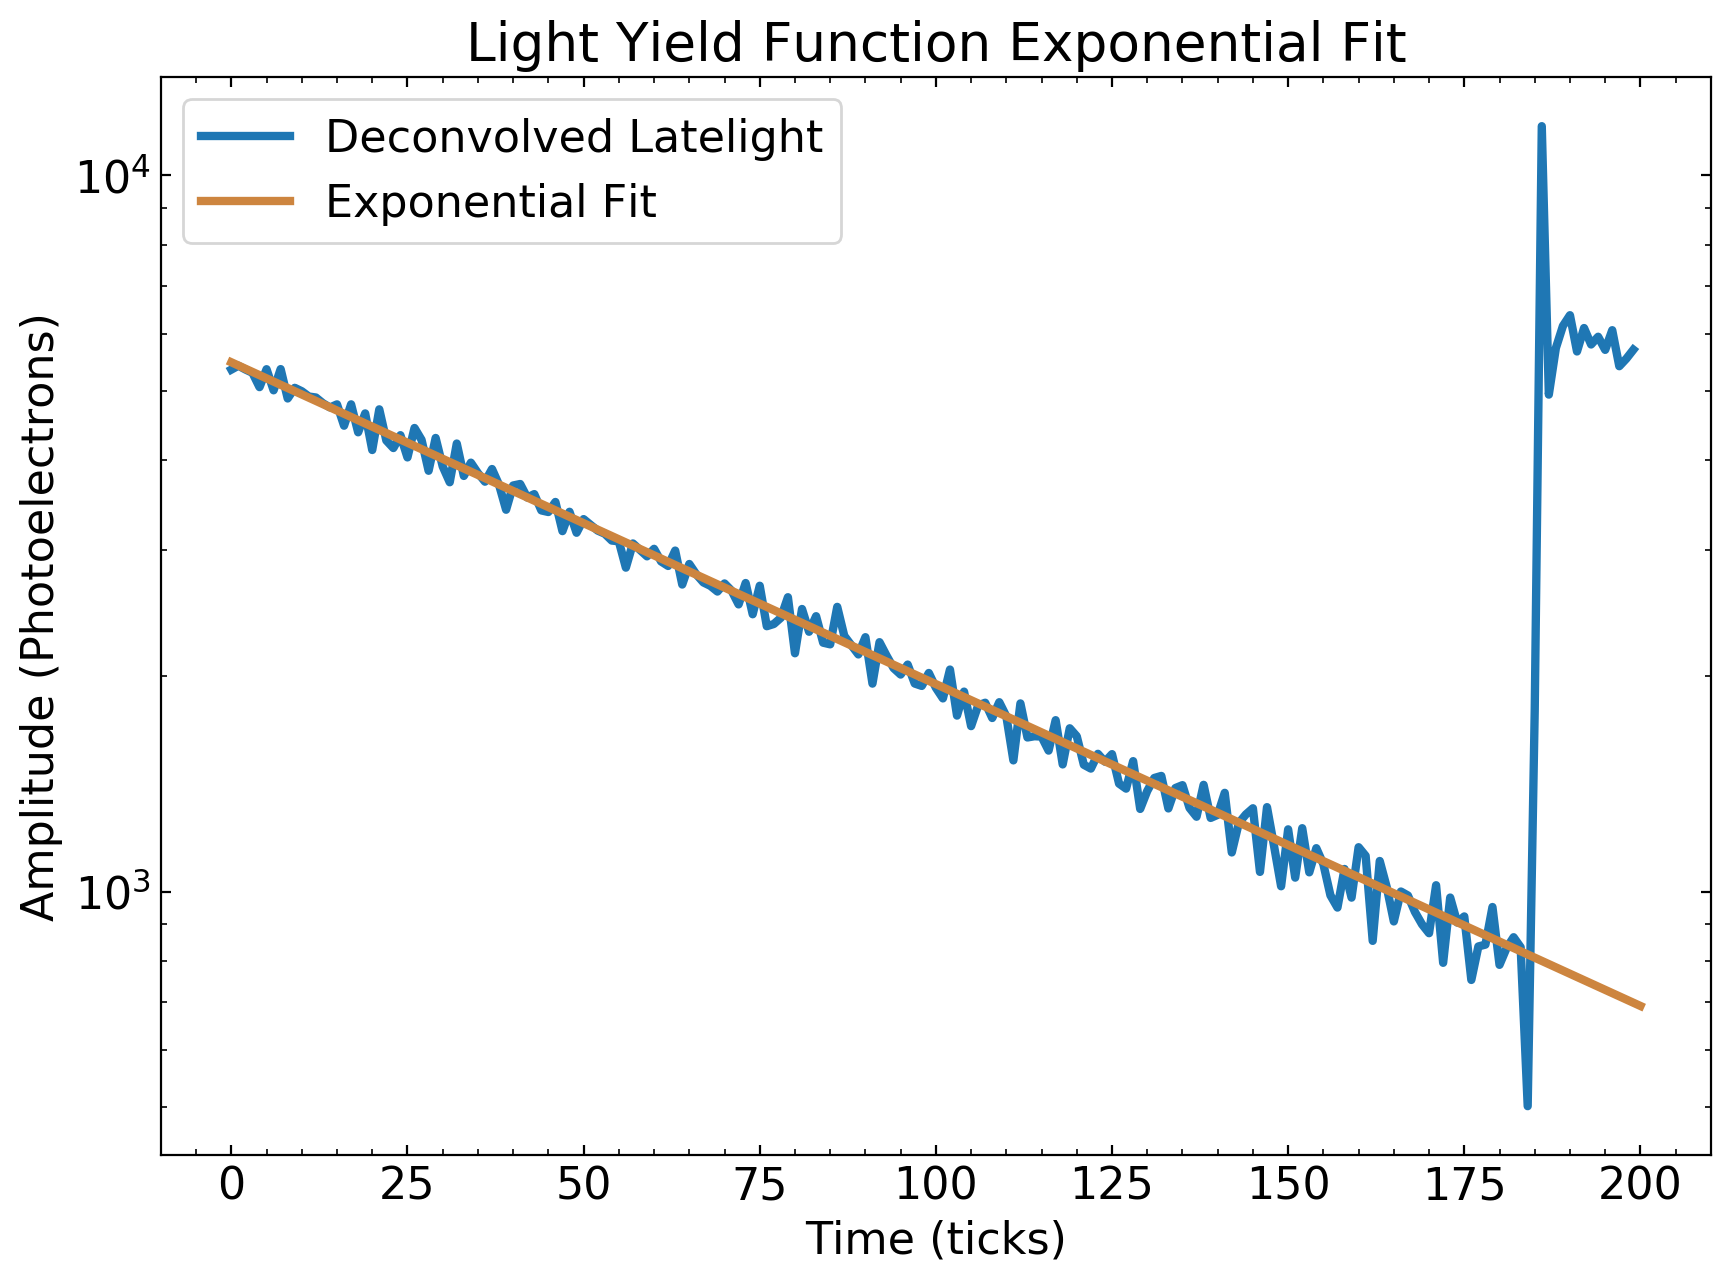

tau = 1510.0649560729712 ns
variance = 7.9260185934189336 ns
[  96.64415719 5482.04809555]


In [60]:
# Try fitting

st = 0
en = 175

# Exponential fit without constant
#par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(st, en, en-st), ydata=dc_res[st:en]+abs(np.mean(dc_res[:10])), p0=(96, 10000))
par, cov = optimize.curve_fit(f=expfun, xdata=np.linspace(st, en, en-st), ydata=dc_res[st:en], p0=(10, 96))

fig, ax = plt.subplots(figsize =(10, 7))
#ax.plot(dc_res+abs(np.mean(dc_res[:10])), label="Sum of Deconvolved Muon Waveforms")
ax.plot(dc_res, label="Deconvolved Latelight")
ax.plot(np.linspace(0, len(dc_res),len(dc_res)), [expfun(i, par[0], par[1]) for i in np.linspace(0, len(dc_res),len(dc_res))], color="peru", label="Exponential Fit")
plt.legend()
ax.set_title("Light Yield Function Exponential Fit")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (Photoelectrons)")
plt.yscale("log")
#plt.ylim(bottom=10e2)
plt.show()

print(f"tau = {par[0]*15.625} ns")
print(f"variance = {cov[0][0]*15.625} ns")
print(par)

In [61]:
# Question: Introduce additive noise to the response function -- How to replicate existing situation
# Noise level


In [62]:
# Simulate response functions with different kernels
# Imitate wf_28
testkwf28 = np.copy(testkernel)
testkwf28[25:50] += [-2((i-5)**3+(i-5)**2) for i in np.linspace(4,5,25)]

# Plot the kernel
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(testkwf28, color="peru", linewidth=0.5)
ax.set_title("Kernel")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
#ax.set_ylim(1900, 2100)
#ax.set_xlim(12,200)
plt.show()

TypeError: 'int' object is not callable

In [ ]:
# Conduct the same verification test using a real kernel
